# 6 - Frequent pattern mining - Association Rules

A completamento dell'analisi del dataset, applico l'algoritmo Apriori e l'algoritmo di scoperta di regole di associazione al set di dati originale, a seguito delle dovute operazioni di pulizia.

In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_excel('Online Retail.xlsx')

In [4]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [5]:
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


### Costruisco il dataset delle transazioni binarizzato, tale dataset rappresenta sulle righe ogni singola transazione (carrello della spesa) e sulle colonne ogni prodotto presente nel dataset, il cui valore è uguale a 1 se il prodotto è presente nel carrello, 0 altrimenti.

In [8]:
trans_df = df.groupby(['InvoiceNo', 'Description'])[
    'Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [9]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
trans_df = trans_df.applymap(encode_units)
trans_df.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Per la ricerca di pattern frequenti seleziono una soglia minima di supporto pari a 0,02. Ciò sta ad indicare che seleziono come frequenti esclusivamente gli insiemi di items che occorrono insieme in almeno il 2% delle transazioni totali.

In [10]:
frequent_itemsets = apriori(trans_df, min_support=0.02,
                            use_colnames=True)

In [11]:
frequent_itemsets.head()

,support,itemsets
0,0.023447,(3 STRIPEY MICE FELTCRAFT)
1,0.024198,(4 TRADITIONAL SPINNING TOPS)
2,0.047846,(6 RIBBONS RUSTIC CHARM)
3,0.021894,(60 CAKE CASES DOLLY GIRL DESIGN)
4,0.030962,(60 CAKE CASES VINTAGE CHRISTMAS)


### Per cercare le regole di associazione, utilizzo come criterio di selezione l'indice di correlazione lift, il quale rappresenta i il valore della correlazione tra l'antecedent ed il consequent di ogni regola. Un valore di lift pari ad 1 indica la mancanza di correlazione, mentre valori inferiori ad 1 indicano una correlazione negativa. Poichè siamo alla ricerca di regole positivamente correlate, utilizzeremo come soglia di lift il valore 1.

In [13]:
rules = association_rules(frequent_itemsets, metric="lift",
                          min_threshold=1)

In [14]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.041483,0.066132,0.022695,0.547101,8.272837,0.019952,2.061980
1,(PACK OF 72 RETROSPOT CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.066132,0.041483,0.022695,0.343182,8.272837,0.019952,1.459334
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.049098,0.039228,0.020942,0.426531,10.872990,0.019016,1.675367
3,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.039228,0.049098,0.020942,0.533844,10.872990,0.019016,2.039880
4,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.049098,0.052655,0.032064,0.653061,12.402571,0.029479,2.730582


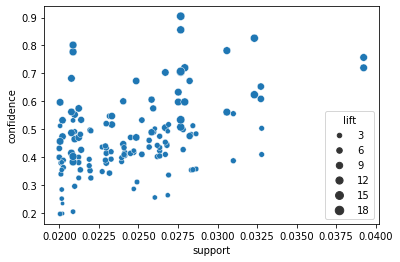

In [16]:
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.show()

# OSSERVAZIONE

### La maggior parte delle regole di associazione contengono gli stessi prodotti ma di diverso colore o quantità. Proviamo dunque a vedere come cambiano le regole assimilando i prodotti uguali.

In [17]:
exclude_set = {'WHITE', 'RED','BLUE', 'YELLOW', 'PINK', 'BLACK', 
               'DARK_GRAY', 'GRAY','LIGHT_GRAY', 'MAGENTA', 'ORANGE',
               'GREEN', 'CYAN', 'BROWN', 'SILVER','PURPLE', 'IVORY',
               'STRAWBERRY', 'SMALL', 'MEDIUM', 'LARGE','ASSORTED COLOUR'}

In [19]:
df['AggregatedDescription'] = ''

In [45]:
for i, row in df.iterrows():
    #interset = set.intersection(set(row['Description'].split(' ')), colorset)
    #print(' '.join(set(row['Description']) - interset))
    df.loc[i,'AggregatedDescription'] = ' '.join(
        s for s in row['Description'].split(' ') if s not in exclude_set)

In [52]:
df = pd.read_csv('aggregatedDescription.csv')

In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,AggregatedDescription
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,HANGING HEART T-LIGHT HOLDER
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,METAL LANTERN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WOOLLY HOTTIE HEART.


In [55]:
import re
#ALARM CLOCK BAKELIKE
#ALARM CLOCK BAKELIKE 
re.search('([^ ]+)(\s+[^ ]+)*','ALARM').group()

'ALARM'

In [39]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,AggregatedDescription
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,HANGING HEART T
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,METAL LANTERN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WOOLLY HOTTIE HEART
...,...,...,...,...,...,...,...,...,...
354313,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,FAIRY TALE COTTAGE NIGHT LIGHT
354314,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,CAKE STAND HANGING STRAWBERY
354315,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,SET OF 3 HANGING OWLS OLLIE BEAK
354316,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,RETROSPOT ROUND CAKE TINS


In [57]:
import re
for i, row in df.iterrows():
    res = re.search('([^ ]+)(\s+[^ ]+)*',
                    df.loc[i,'AggregatedDescription']).group()
#    print(res)
    df.loc[i,'AggregatedDescription'] = res
#    print(i)

In [106]:
df.to_csv('aggregatedDescription2.csv', index=False)

In [107]:
trans_df = df.groupby(['InvoiceNo', 'AggregatedDescription'])
        ['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [108]:
trans_df = trans_df.applymap(encode_units)
trans_df.head()

AggregatedDescription,& BREAKFAST TRAY,& ROSEBUD RING,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 HEN+CHICKS IN BASKET,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL TUBE WOODLAND,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR,ZINC T-LIGHT HOLDER STARS,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY,ZINC/GLASS CANDLEHOLDER
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
frequent_itemsets = apriori(trans_df, min_support=0.02, use_colnames=True)

In [110]:
frequent_itemsets.head()

,support,itemsets
0,0.022412,(3 STRIPEY MICE FELTCRAFT)
1,0.037734,(6 RIBBONS RUSTIC CHARM)
2,0.025777,(60 CAKE CASES VINTAGE CHRISTMAS)
3,0.035270,(60 TEATIME FAIRY CAKE CASES)
4,0.026678,(72 SWEETHEART FAIRY CAKE CASES)


In [111]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [112]:
rules.iloc[::2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.037673,0.044583,0.027519,0.730463,16.384215,0.025839,3.544652
2,(HEART OF WICKER),(HANGING HEART T-LIGHT HOLDER),0.106591,0.126480,0.035210,0.330327,2.611701,0.021728,1.304398
4,(JUMBO BAG RETROSPOT),(JUMBO BAG BAROQUE),0.086943,0.037613,0.020850,0.239806,6.375558,0.017579,1.265976
6,(JUMBO BAG),(JUMBO BAG RETROSPOT),0.037373,0.086943,0.023734,0.635048,7.304152,0.020484,2.501855
8,(JUMBO BAG POLKADOT),(JUMBO BAG RETROSPOT),0.048789,0.086943,0.030403,0.623153,7.167333,0.026161,2.422882
10,(JUMBO BAG RETROSPOT),(JUMBO SHOPPER VINTAGE PAISLEY),0.086943,0.045004,0.022412,0.257775,5.727830,0.018499,1.286666
12,(JUMBO BAG RETROSPOT),(JUMBO STORAGE BAG SUKI),0.086943,0.043261,0.024515,0.281963,6.517646,0.020754,1.332436
14,(LUNCH BAG RETROSPOT),(JUMBO BAG RETROSPOT),0.067296,0.086943,0.022652,0.336607,3.871564,0.016801,1.376344
16,(LUNCH BAG SKULL.),(LUNCH BAG CARS),0.059845,0.052995,0.024154,0.403614,7.616049,0.020983,1.587907
18,(LUNCH BAG SKULL.),(LUNCH BAG POLKADOT),0.059845,0.050952,0.026558,0.443775,8.709610,0.023508,1.706230


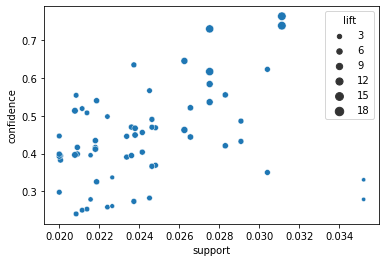

In [66]:
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.show()

## L'aggregazione ha consentito di ricavare delle regole più interessanti, anche se si nota l'eccessiva presenza di alcuni prodotti. Proviamo ad eliminare tali prodotti per capire come cambiano le regole

In [90]:
df = pd.read_csv('aggregatedDescription2.csv')

In [91]:
trans_df = df.groupby(['InvoiceNo', 'AggregatedDescription'])[
    'Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [92]:
trans_df = trans_df.applymap(encode_units)
trans_df.head()

AggregatedDescription,& BREAKFAST TRAY,& ROSEBUD RING,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 HEN+CHICKS IN BASKET,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL TUBE WOODLAND,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR,ZINC T-LIGHT HOLDER STARS,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY,ZINC/GLASS CANDLEHOLDER
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
for column in trans_df.columns[1:]:
    if 'JUMBO BAG' in column or 'LUNCH BAG' in column:
        del trans_df[column]

In [114]:
trans_df

AggregatedDescription,& BREAKFAST TRAY,& ROSEBUD RING,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 HEN+CHICKS IN BASKET,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL TUBE WOODLAND,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR,ZINC T-LIGHT HOLDER STARS,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY,ZINC/GLASS CANDLEHOLDER
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
frequent_itemsets = apriori(trans_df, min_support=0.02, use_colnames=True)

In [116]:
frequent_itemsets.head()

,support,itemsets
0,0.022412,(3 STRIPEY MICE FELTCRAFT)
1,0.037734,(6 RIBBONS RUSTIC CHARM)
2,0.025777,(60 CAKE CASES VINTAGE CHRISTMAS)
3,0.035270,(60 TEATIME FAIRY CAKE CASES)
4,0.026678,(72 SWEETHEART FAIRY CAKE CASES)


In [117]:
rules = association_rules(frequent_itemsets, 
                          metric="confidence", min_threshold=0.2)

In [118]:
rules.iloc[::2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.037673,0.044583,0.027519,0.730463,16.384215,0.025839,3.544652
2,(HEART OF WICKER),(HANGING HEART T-LIGHT HOLDER),0.106591,0.126480,0.035210,0.330327,2.611701,0.021728,1.304398
4,(PAPER CHAIN KIT 50'S CHRISTMAS),(PAPER CHAIN KIT VINTAGE CHRISTMAS),0.056781,0.040678,0.026257,0.462434,11.368223,0.023948,1.784566
6,(PARTY BUNTING),(SPOTTY BUNTING),0.077510,0.054557,0.021571,0.278295,5.100943,0.017342,1.310012
8,(REGENCY CAKESTAND 3 TIER),(REGENCY TEACUP AND SAUCER),0.084720,0.042120,0.021390,0.252482,5.994383,0.017822,1.281415
10,(ROSES REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.040738,0.084720,0.021150,0.519174,6.128095,0.017699,1.903557
12,(ROSES REGENCY TEACUP AND SAUCER),(REGENCY TEACUP AND SAUCER),0.040738,0.042120,0.031124,0.764012,18.139013,0.029408,4.059017
14,(WOODEN FRAME ANTIQUE),(WOODEN PICTURE FRAME FINISH),0.047107,0.051313,0.027519,0.584184,11.384741,0.025102,2.281505


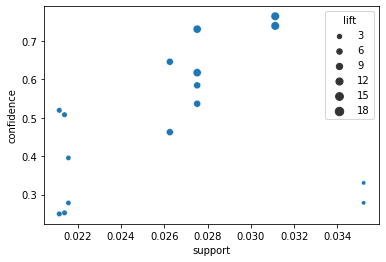

In [102]:
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.show()

## A seguito di diverse operazioni di modifica, le associazioni frequenti scoperte interessano in ogni caso oggetti della stessa tipologia ma con caratteristiche (stile,colore, etc) diverse. 
## Possiamo perciò affermare che un un notevole numero di carrelli è composto da stessi porodotti con caratteristiche differenti.